In [1]:
%load_ext autoreload
%autoreload 2
    

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
import bets
import os
import glob
import datetime as dt
import time
#import ot
import json
import requests
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import sidetable
nba = bets.nba()
import seaborn as sns
import matplotlib.pyplot as plt
import re
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from nba_api.stats.endpoints import leaguegamefinder,BoxScoreSummaryV2,LeagueDashOppPtShot,PlayerProfileV2,GameRotation,LeagueDashPlayerShotLocations

What changes to make to this model
1. Want to have decay for our rolling estimates  
   a.This will be both at the team level (these are currently in the query) and player level  
   b.this will have to be done in pandas, in the script  
   c. need to re-write sql query to pull in values not adjusted  
2. New One-Hot Variables  
   a. Top Scorer -  highest moving average on team  
   b. Top Shooter - Takes most threes on team  
   c. Volume Shooter - in  90th+ percentile of total threes taken  
   d. corner merchant - over 33% of threes from corner - look into number  
   e. starter - this is created but can help to be added
   f. nans filled
   g. reduce threes made to a max of 8 and bin if they made more than 8 in a game
4. Interaction Terms:  
   a. Rolling Three % * Home  
   b. Player Off rating - team off rating  
   c.
5. Add-in odds

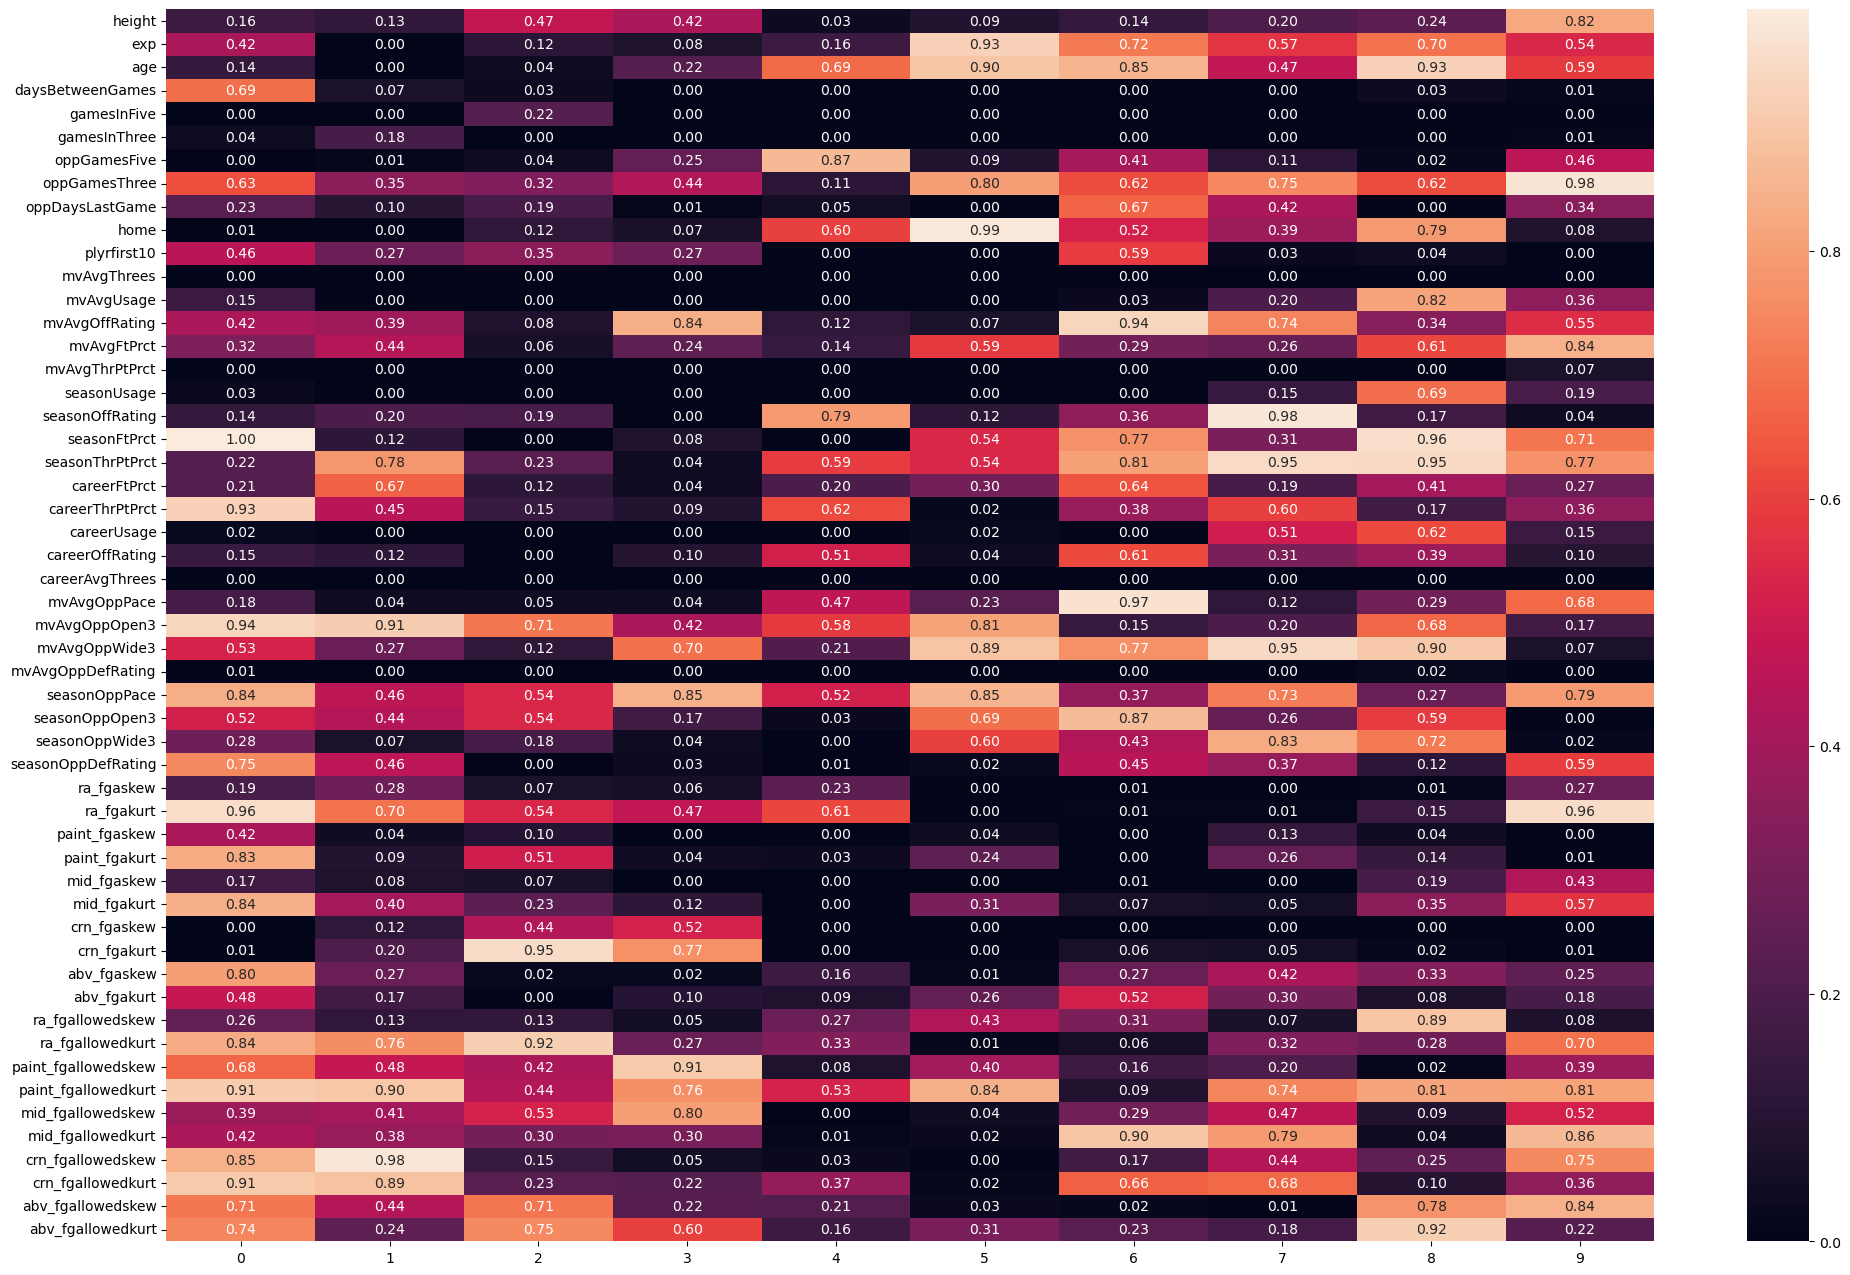

In [3]:
#what is currently used in the model?
cur = pd.read_pickle('data/model/upThrLog.pkl')
plt.figure(figsize=(24,16))
sns.heatmap(cur.pvalues,annot=True,fmt='.2f')
plt.show()

In [4]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import OneHotEncoder,StandardScaler

In [5]:
def cProbOutput(predsDf):
    c = sorted([c for c in predsDf.columns if isinstance(c,int)],reverse=True)
    finalo = pd.DataFrame(np.array([v for r in predsDf[c].cumsum(axis=1).values for v in r]).reshape(predsDf[c].shape),
                         columns=c,index=predsDf.index)
    
    
    df = finalo.filter(predsDf.columns).join(predsDf.name)
    return df


In [6]:
def oheActuals(actuals):
    mx = max(actuals)
    return np.array([[0] * y +[1] + [0]*(mx-y) for y in actuals])
    
def oheOvers(actuals):
    mx = max(actuals)
    return np.array([[1] * (y+1) + [0]*(mx-y) for y in actuals])
    
def brier_scores(actuals,preds,cumlative=False):
    '''Will create a brier score to compare models
    Inputs: an array of actuals one hot encoded, a data frame of predictions from model
    Outputs: score as a float
    '''
    
    if cumlative:
        c= sorted(preds.columns,reverse=True)
        preds = preds.filter(c).cumsum(axis=1).filter(preds.columns)
        bscore = (preds.sub(oheOvers(actuals)) ** 2).sum(axis=1).mean()
    else:
        bscore =  (preds.sub(oheActuals(actuals)) ** 2).sum(axis=1).mean()
    print('{}brier score of:  {:.3f}'.format('cumlative ' if cumlative else '', bscore))
    return bscore
        
#def score_comp(actuals,preds,

#base = np.tile(np.array(ohe).mean(axis=0), (np.array(ohe).shape[0], 1))

In [7]:
addMrkts = 'player_points,player_points_alterante,player_rebounds,player_rebounds_alternate,player_first_basket,player_assists,player_assists_alternate'
mrkts = '&markets=player_threes,player_threes_alternate'
apiKey = 'apiKey=153deeb03ca7b659e72d18e28219d1a8'
oddsType = '&oddsFormat=american'
regions = '&regions=us'
books = '&bookmakers=draftkings%2Cfanduel%2Cespnbet'
inputs = ['{}',apiKey,regions,mrkts,oddsType,books]
url = '''https://api.the-odds-api.com/v4/sports/basketball_nba/events/{}/odds?{}{}{}&dateFormat=iso{}{}'''.format(*inputs)

In [8]:
#Going to run the back testing on '24 season

In [9]:
#update model to use '22-'23
trainData = nba.threeData('data/sql/thrTesting.sql')


In [10]:
curMod= pd.read_pickle('data/model/upThrLog.pkl')
params = curMod.params.index.tolist()

In [11]:
# import pickle
# pickle.dump(dct,open('data/model/newFeatsScaled.pkl','wb'))

In [12]:
def rescaleData(X):
    ss = StandardScaler()
    d = {}
    for col in X.columns:
        if isinstance(X['name'].values[0],str) ==False:
            X[col] = ss.fit_transform(X[col].values.reshape(-1,1))
            d[col] = {'mean':ss.mean_,'std':ss.var_**.5}
    return X,d

def weighted_moving_avg(data,min,periods,col,grping):
    mvgAvg = data.groupby(grping)[col].rolling(periods,closed='left',min_periods=min, win_type='exponential').mean()
    return mvgAvg.reset_index(name='{}Mv'.format(col)).set_index('level_1').drop([grping],axis=1)
    
def model_data(trainData,rescale=False):
    yst = (dt.datetime.today()+ pd.to_timedelta(-1,unit='day')).strftime(format='%Y-%m-%d')
    X = trainData[trainData.season.between('2021-22', '2023-24')]
    Xtest = trainData[trainData.game_date.between('2024-10-01',yst)]
    y = trainData[trainData.season.between('2021-22', '2023-24')].threesMade.values
    yTest = Xtest[Xtest.game_date.between('2024-10-01',yst)].threesMade.values
    ybin = [10 if v>9 else v for v in y]
    X['abv_kurtSkew'] = X.abv_fgakurt * X.abv_fgaskew
    X['crn_kurtSkew'] = X.crn_fgakurt * X.crn_fgaskew
    X = X.join(weighted_moving_avg(X,5,15,'crn_fga','player_id'))
    X = X.join(weighted_moving_avg(X,5,15,'abv_fga','player_id'))
    # X = X.join(weighted_moving_avg(X,5,15,'crn_fgAllowed','team_id'))
    # X = X.join(weighted_moving_avg(X,5,15,'abv_fgAllowed','team_id'))
    X = nba.cleanNaThr(X)
    Xtest['abv_kurtSkew'] = Xtest.abv_fgakurt * Xtest.abv_fgaskew
    Xtest['crn_kurtSkew'] = Xtest.crn_fgakurt * Xtest.crn_fgaskew
    Xtest = Xtest.join(weighted_moving_avg(Xtest,5,15,'crn_fga','player_id'))
    Xtest = Xtest.join(weighted_moving_avg(Xtest,5,15,'abv_fga','player_id'))
    Xtest = nba.cleanNaThr(Xtest)
    if rescale:
        X,d = rescaleData(X)
        for col in d.keys():
            Xtest[col] = (Xtest[col] - d.get(col).get('mean')) / d.get(col).get('std')
    else:
        X = nba.scaleData(X)
        Xtest = nba.scaleData(Xtest)
    
    yTbin = np.array([10 if y > 9 else y for y in yTest])
    return X, ybin, Xtest,yTbin

In [13]:
X,ybin,Xtest,yTbin = model_data(trainData)

In [14]:
def modTesting(y,ytest,X,Xtest,params):
    newMod = sm.MNLogit(endog = np.array(ybin), exog = X.filter(params),)
    upModel = newMod.fit(method = 'bfgs',maxiter=1000)
    p = upModel.predict(Xtest.filter(params))

    c = sorted(p.columns,reverse=True)
    bscore = np.mean([brier_scores(ytest,p,cumlative = True),brier_scores(ytest,p)])
    print('Mean Score {:.3f}'.format(bscore))
    print(p.mean())
    print('\nCumlative Sum of Above')
    print(p.mean().filter(c).cumsum())
    plt.figure(figsize=(24,16))
    sns.heatmap(upModel.pvalues.sort_index(),annot=True,fmt='.2f',)
    plt.show()
    return upModel

In [15]:
pd.DataFrame(yTbin).value_counts(normalize=True)

0    0.361
1    0.239
2    0.171
3    0.113
4    0.061
5    0.030
6    0.014
7    0.006
8    0.003
9    0.001
10   0.000
Name: proportion, dtype: float64

Current Model Results:
Optimization terminated successfully.
         Current function value: 1.707918
         Iterations: 749
         Function evaluations: 751
         Gradient evaluations: 751
cumlative brier score of:  0.724
brier score of:  0.734
Mean Score 0.729
0    0.255
1    0.282
2    0.209
3    0.124
4    0.065
5    0.035
6    0.017
7    0.008
8    0.004
9    0.001
10   0.001
dtype: float64

Cumlative Sum of Above
10   0.001
9    0.002
8    0.006
7    0.014
6    0.031
5    0.065
4    0.131
3    0.254
2    0.463
1    0.745
0    1.000
dtype: float64


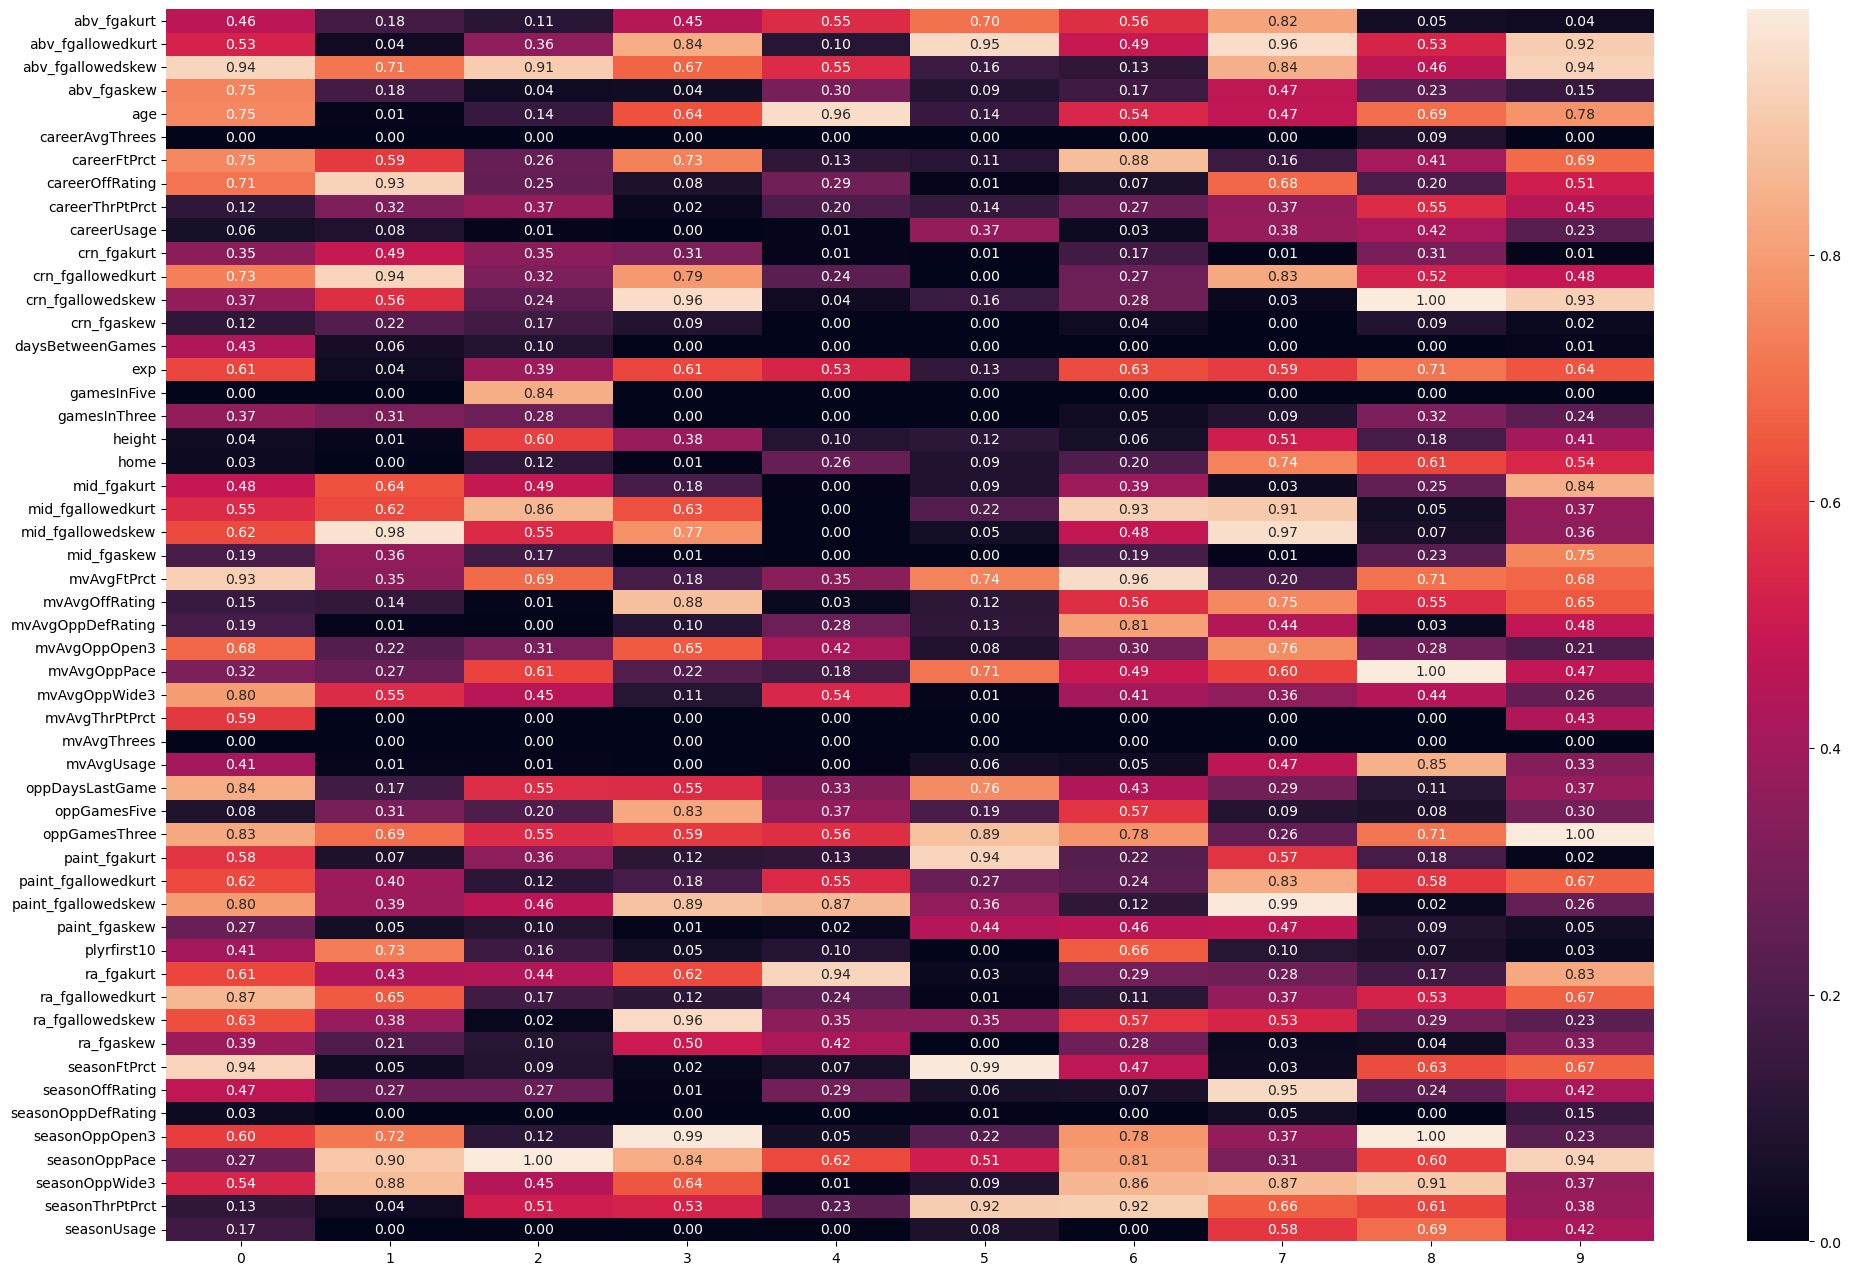

In [16]:

print('Current Model Results:')
modTesting(ybin,yTbin,X,Xtest,params)

Optimization terminated successfully.
         Current function value: 1.707810
         Iterations: 781
         Function evaluations: 783
         Gradient evaluations: 783
cumlative brier score of:  0.724
brier score of:  0.734
Mean Score 0.729
0    0.255
1    0.282
2    0.210
3    0.124
4    0.065
5    0.034
6    0.017
7    0.008
8    0.004
9    0.001
10   0.001
dtype: float64

Cumlative Sum of Above
10   0.001
9    0.002
8    0.006
7    0.013
6    0.030
5    0.065
4    0.130
3    0.254
2    0.464
1    0.745
0    1.000
dtype: float64


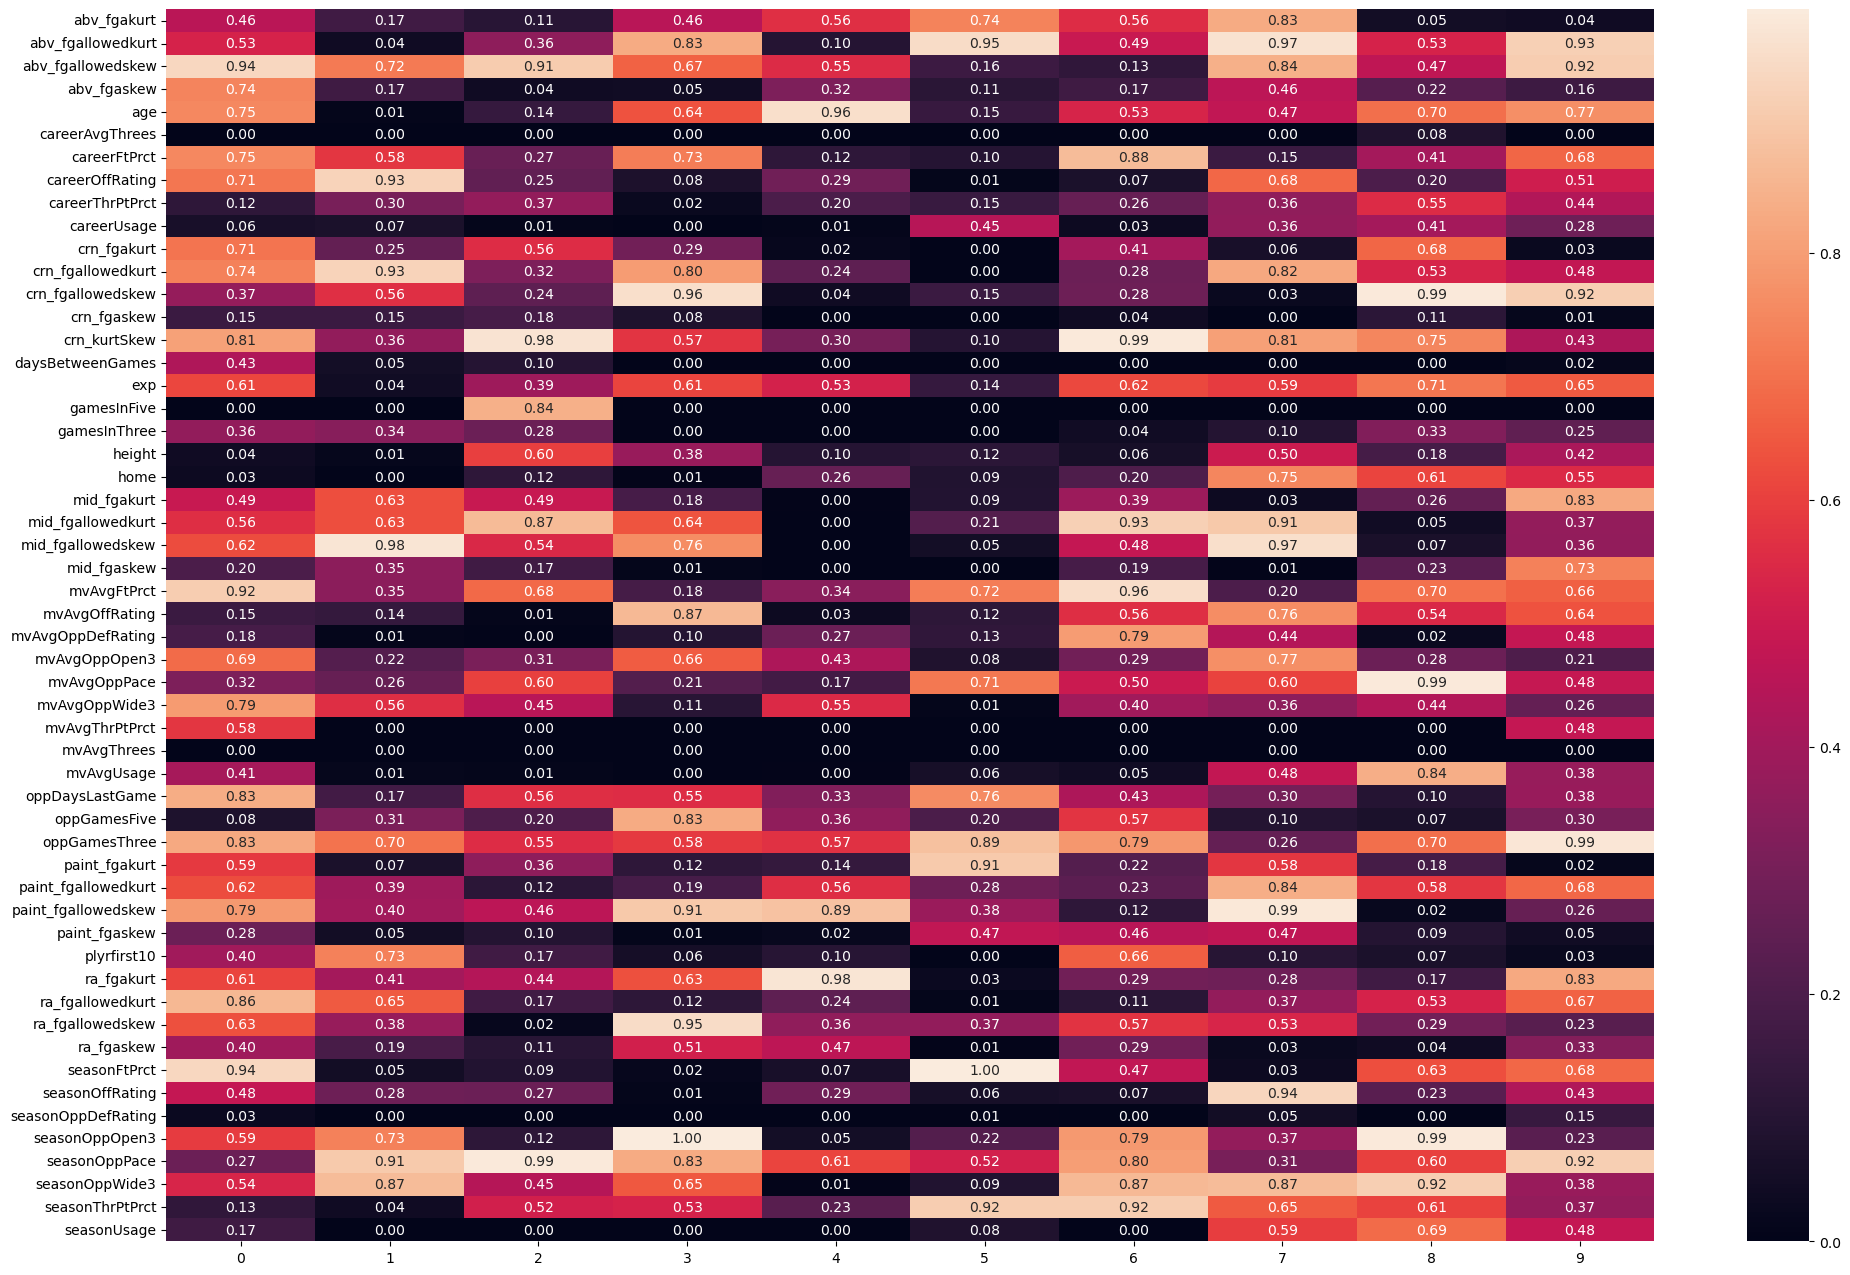

In [17]:
#abv_kurt * abv_skew does not seem significant
interAction = ['crn_kurtSkew']

upParams = params + interAction
upMod = modTesting(ybin,yTbin,X,Xtest,upParams)

Optimization terminated successfully.
         Current function value: 1.709700
         Iterations: 726
         Function evaluations: 727
         Gradient evaluations: 727
cumlative brier score of:  0.734
brier score of:  0.731
Mean Score 0.733
0    0.256
1    0.280
2    0.204
3    0.124
4    0.066
5    0.035
6    0.017
7    0.008
8    0.004
9    0.005
10   0.001
dtype: float64

Cumlative Sum of Above
10   0.001
9    0.006
8    0.010
7    0.017
6    0.034
5    0.069
4    0.135
3    0.259
2    0.464
1    0.744
0    1.000
dtype: float64


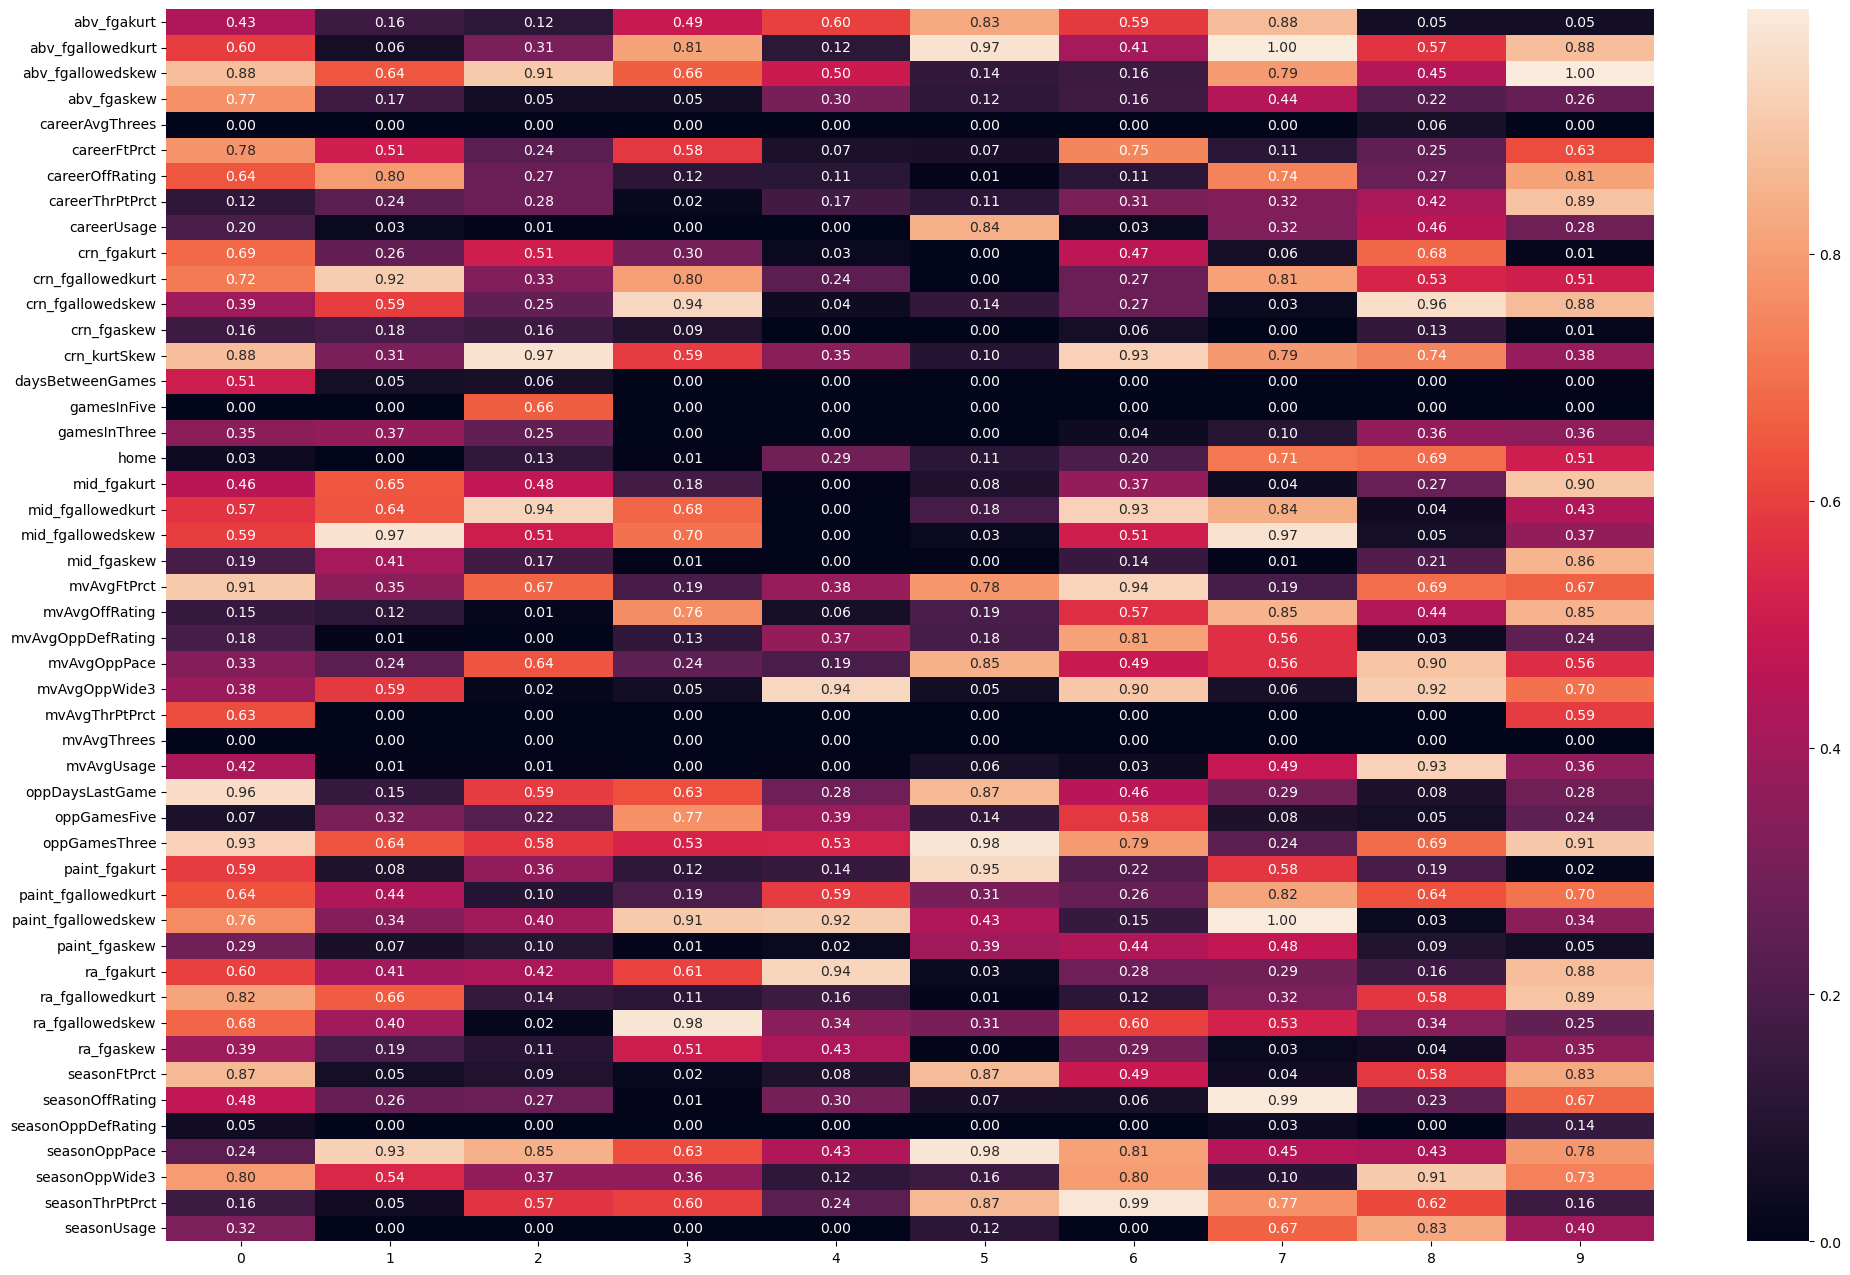

In [18]:
#removing height, age and exp - this improves performance slightly, makes sense to remove
# removing opponent open 3's as this does not seem to have an impact, keeping wide
rmvOpen = ['seasonOppOpen3','mvAvgOppOpen3']
removals = ['age','height','exp','plyrfirst10'] +rmvOpen
noAge = list(set(upParams).difference(removals)) 
upMod = modTesting(ybin,yTbin,X,Xtest,noAge)

In [19]:
seasonFeats = ['seasonOppPace', 'seasonOppWide3','seasonThrPtPrct','seasonFtPrct', 'seasonUsage','seasonOppDefRating','seasonOffRating',
              'oppGamesThree','mvAvgFtPrct']

Optimization terminated successfully.
         Current function value: 1.712345
         Iterations: 635
         Function evaluations: 637
         Gradient evaluations: 637
cumlative brier score of:  0.718
brier score of:  0.725
Mean Score 0.721
0    0.261
1    0.283
2    0.204
3    0.123
4    0.065
5    0.034
6    0.017
7    0.007
8    0.003
9    0.002
10   0.001
dtype: float64

Cumlative Sum of Above
10   0.001
9    0.002
8    0.005
7    0.013
6    0.030
5    0.064
4    0.130
3    0.253
2    0.457
1    0.739
0    1.000
dtype: float64


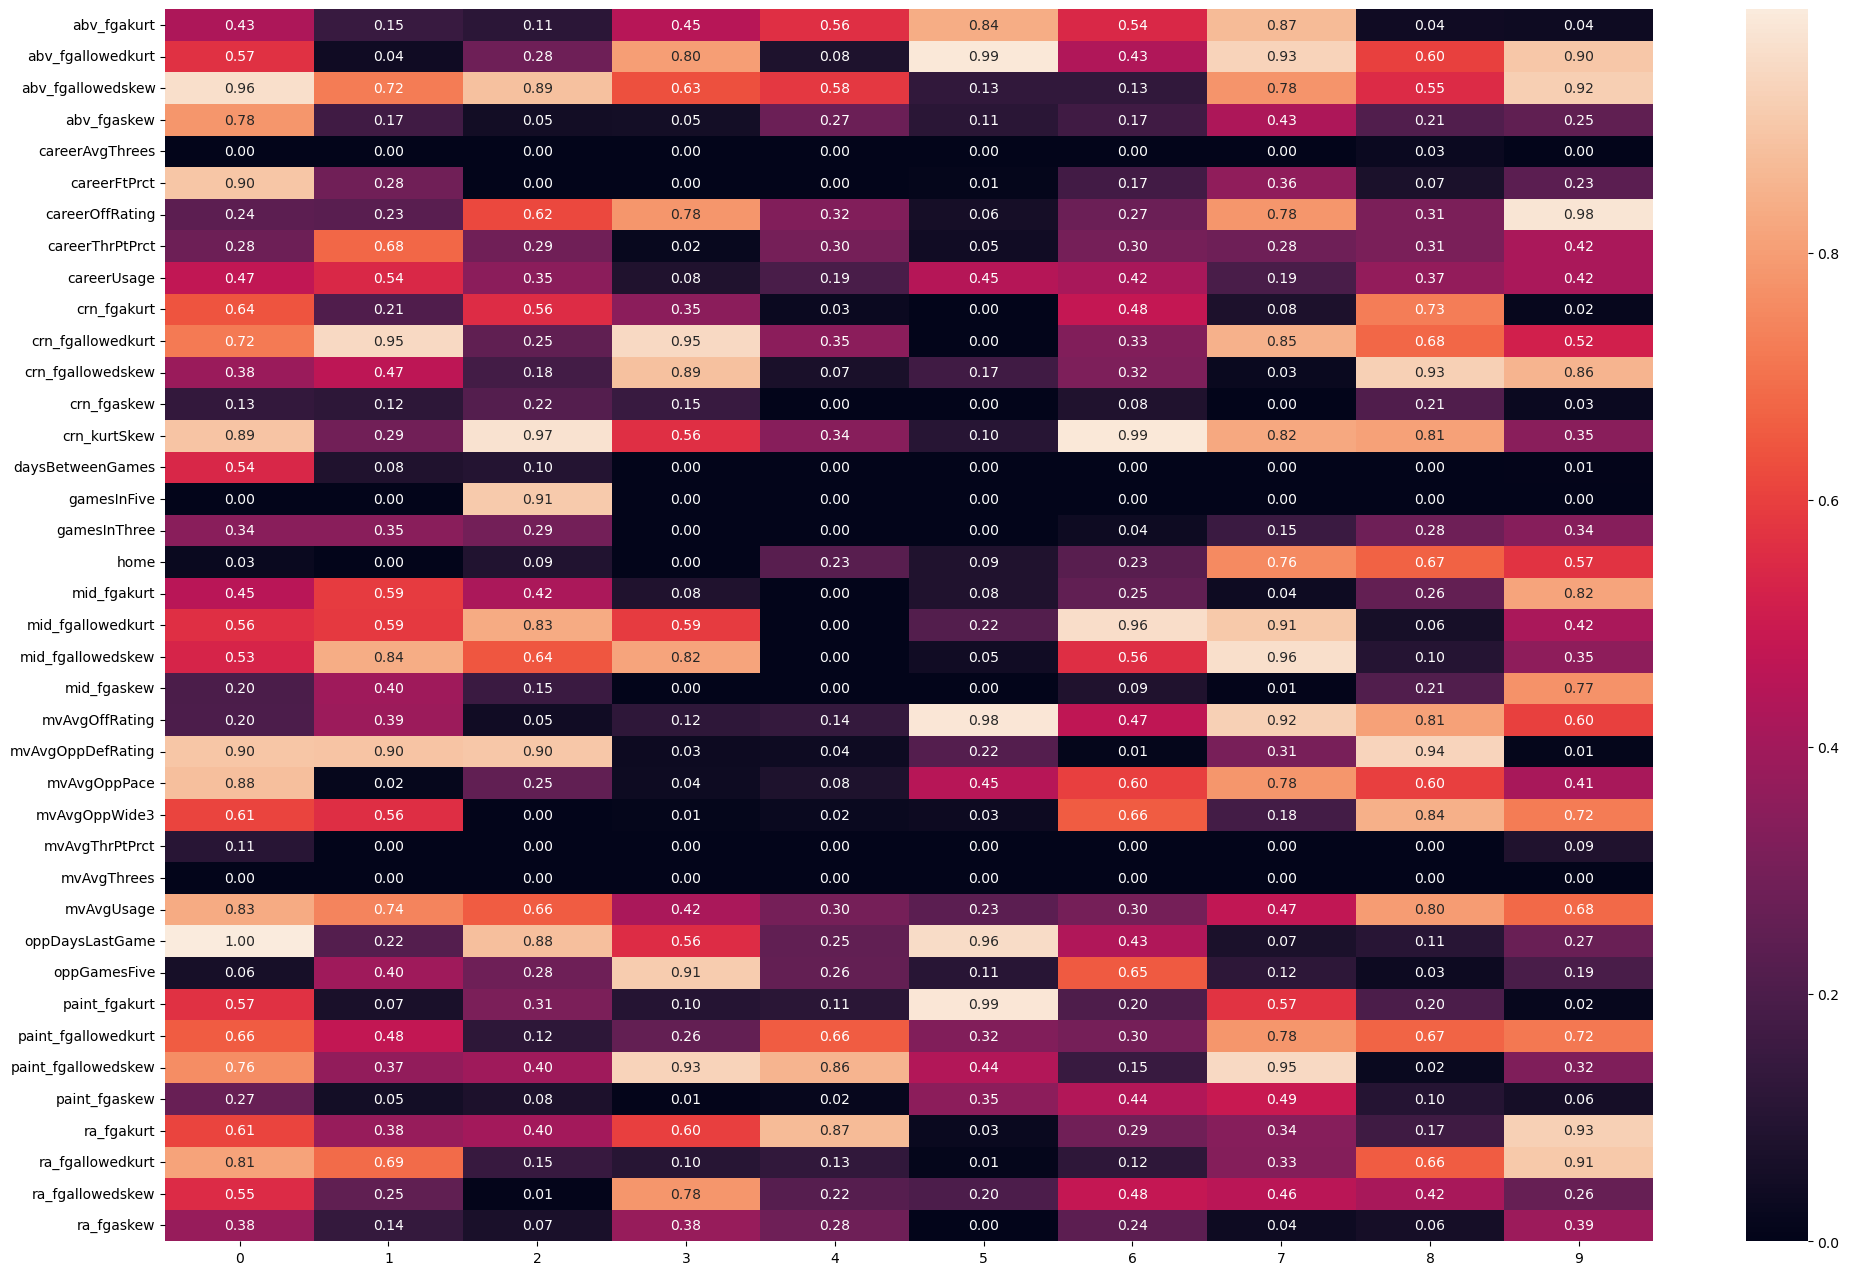

In [20]:
#removing all season information
rmvSeason = [col for col in noAge if col not in seasonFeats]

upMod = modTesting(ybin,yTbin,X,Xtest,rmvSeason)

Optimization terminated successfully.
         Current function value: 1.708800
         Iterations: 646
         Function evaluations: 647
         Gradient evaluations: 647
cumlative brier score of:  0.712
brier score of:  0.722
Mean Score 0.717
0    0.267
1    0.286
2    0.201
3    0.120
4    0.064
5    0.033
6    0.017
7    0.007
8    0.003
9    0.002
10   0.001
dtype: float64

Cumlative Sum of Above
10   0.001
9    0.002
8    0.005
7    0.012
6    0.029
5    0.063
4    0.126
3    0.246
2    0.448
1    0.733
0    1.000
dtype: float64


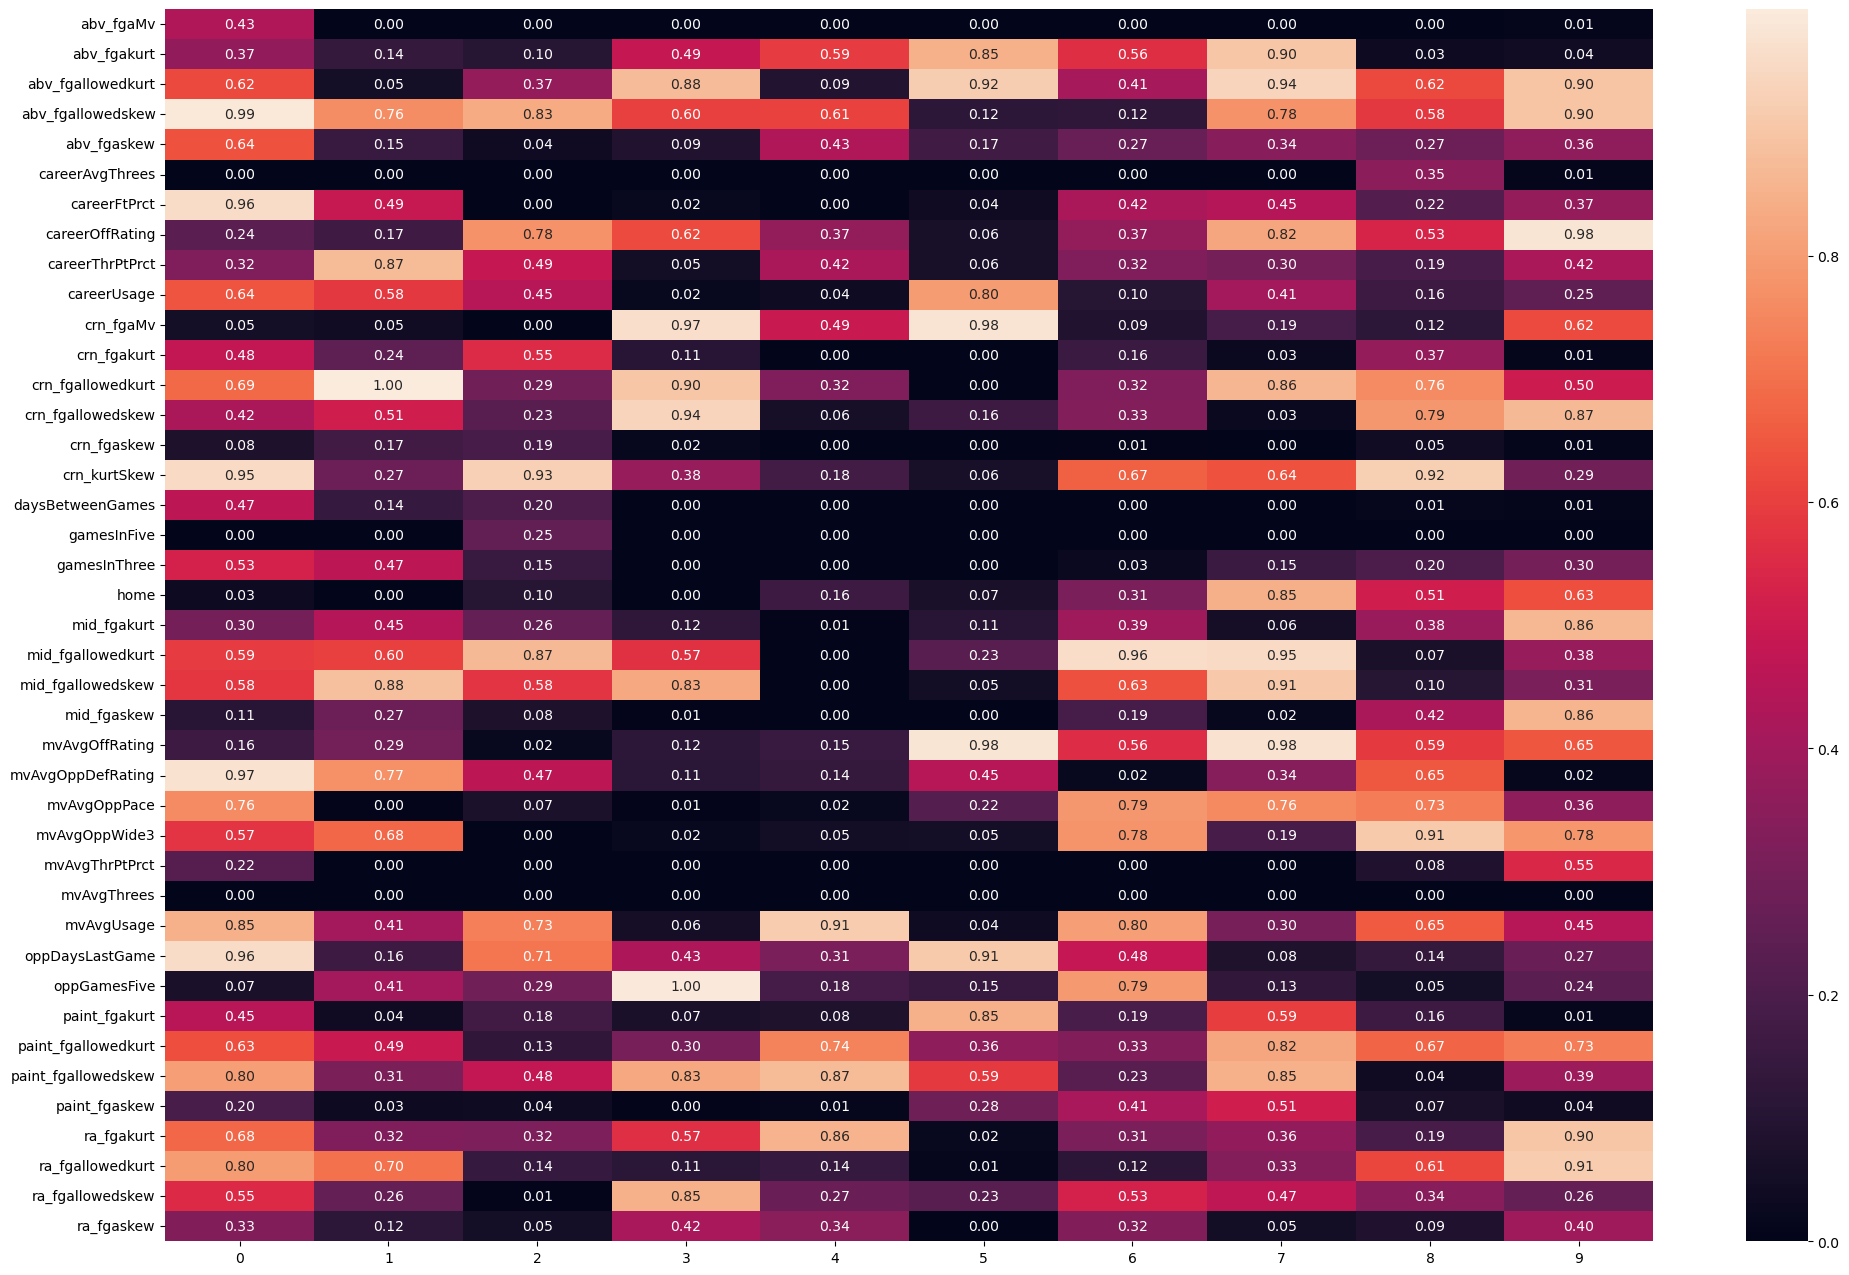

In [21]:
mvAtts = ['abv_fgaMv','crn_fgaMv']
newFeats = rmvSeason + mvAtts
upMod = modTesting(ybin,yTbin,X,Xtest,newFeats)

Optimization terminated successfully.
         Current function value: 1.712806
         Iterations: 570
         Function evaluations: 573
         Gradient evaluations: 573
cumlative brier score of:  0.710
brier score of:  0.722
Mean Score 0.716
0    0.268
1    0.289
2    0.203
3    0.118
4    0.064
5    0.032
6    0.015
7    0.006
8    0.003
9    0.002
10   0.001
dtype: float64

Cumlative Sum of Above
10   0.001
9    0.002
8    0.005
7    0.011
6    0.026
5    0.058
4    0.122
3    0.240
2    0.443
1    0.732
0    1.000
dtype: float64


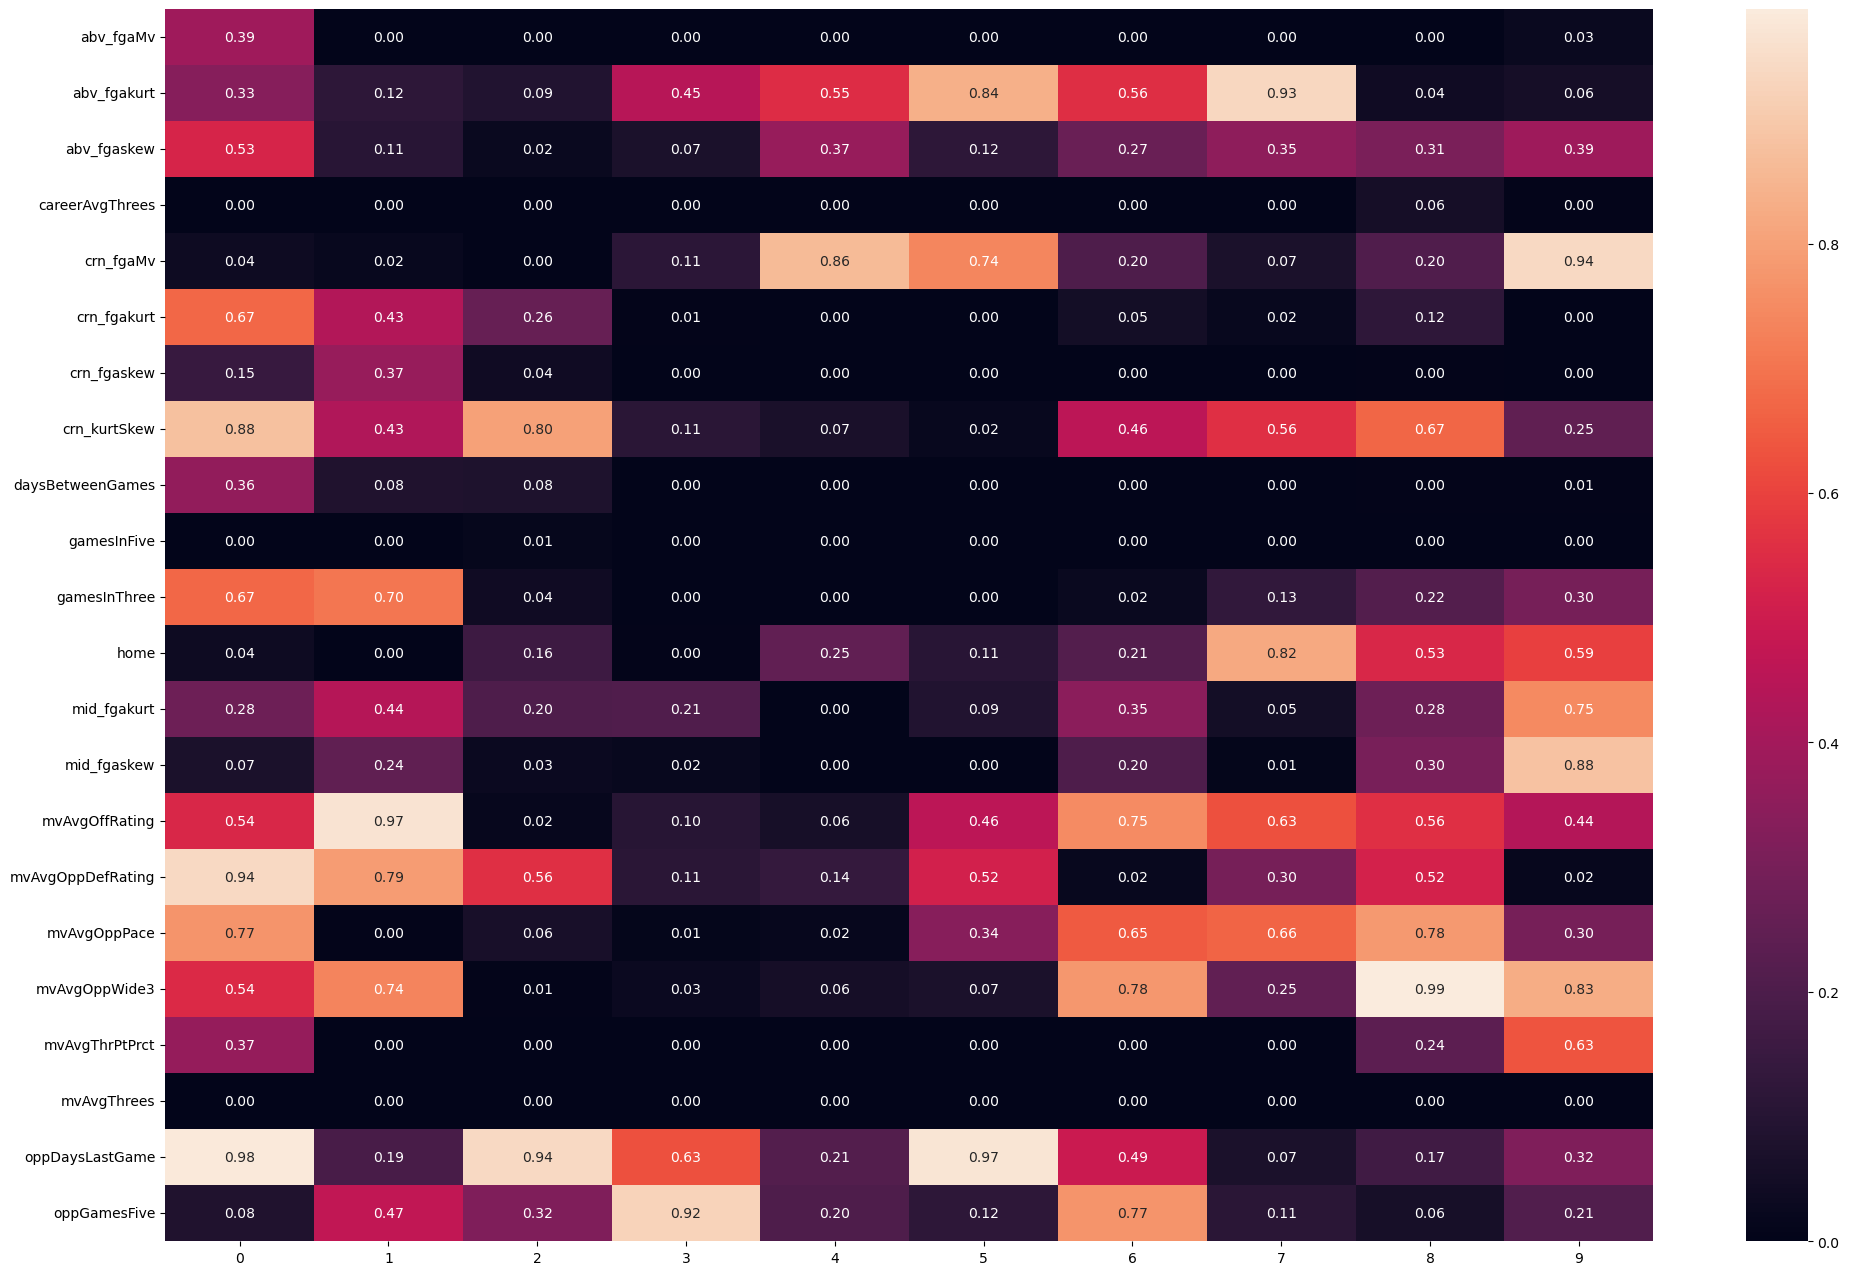

In [22]:
#dropping out paint and ra fields

jumperFeats = [col for col in newFeats if re.search('^paint|ra|mvAvgUsage|fgallowed|^career',col)==None] +['careerAvgThrees']
upMod = modTesting(ybin,yTbin,X,Xtest,jumperFeats,)

Optimization terminated successfully.
         Current function value: 1.712806
         Iterations: 570
         Function evaluations: 573
         Gradient evaluations: 573
cumlative brier score of:  0.710
brier score of:  0.722
Mean Score 0.716
0    0.268
1    0.289
2    0.203
3    0.118
4    0.064
5    0.032
6    0.015
7    0.006
8    0.003
9    0.002
10   0.001
dtype: float64

Cumlative Sum of Above
10   0.001
9    0.002
8    0.005
7    0.011
6    0.026
5    0.058
4    0.122
3    0.240
2    0.443
1    0.732
0    1.000
dtype: float64


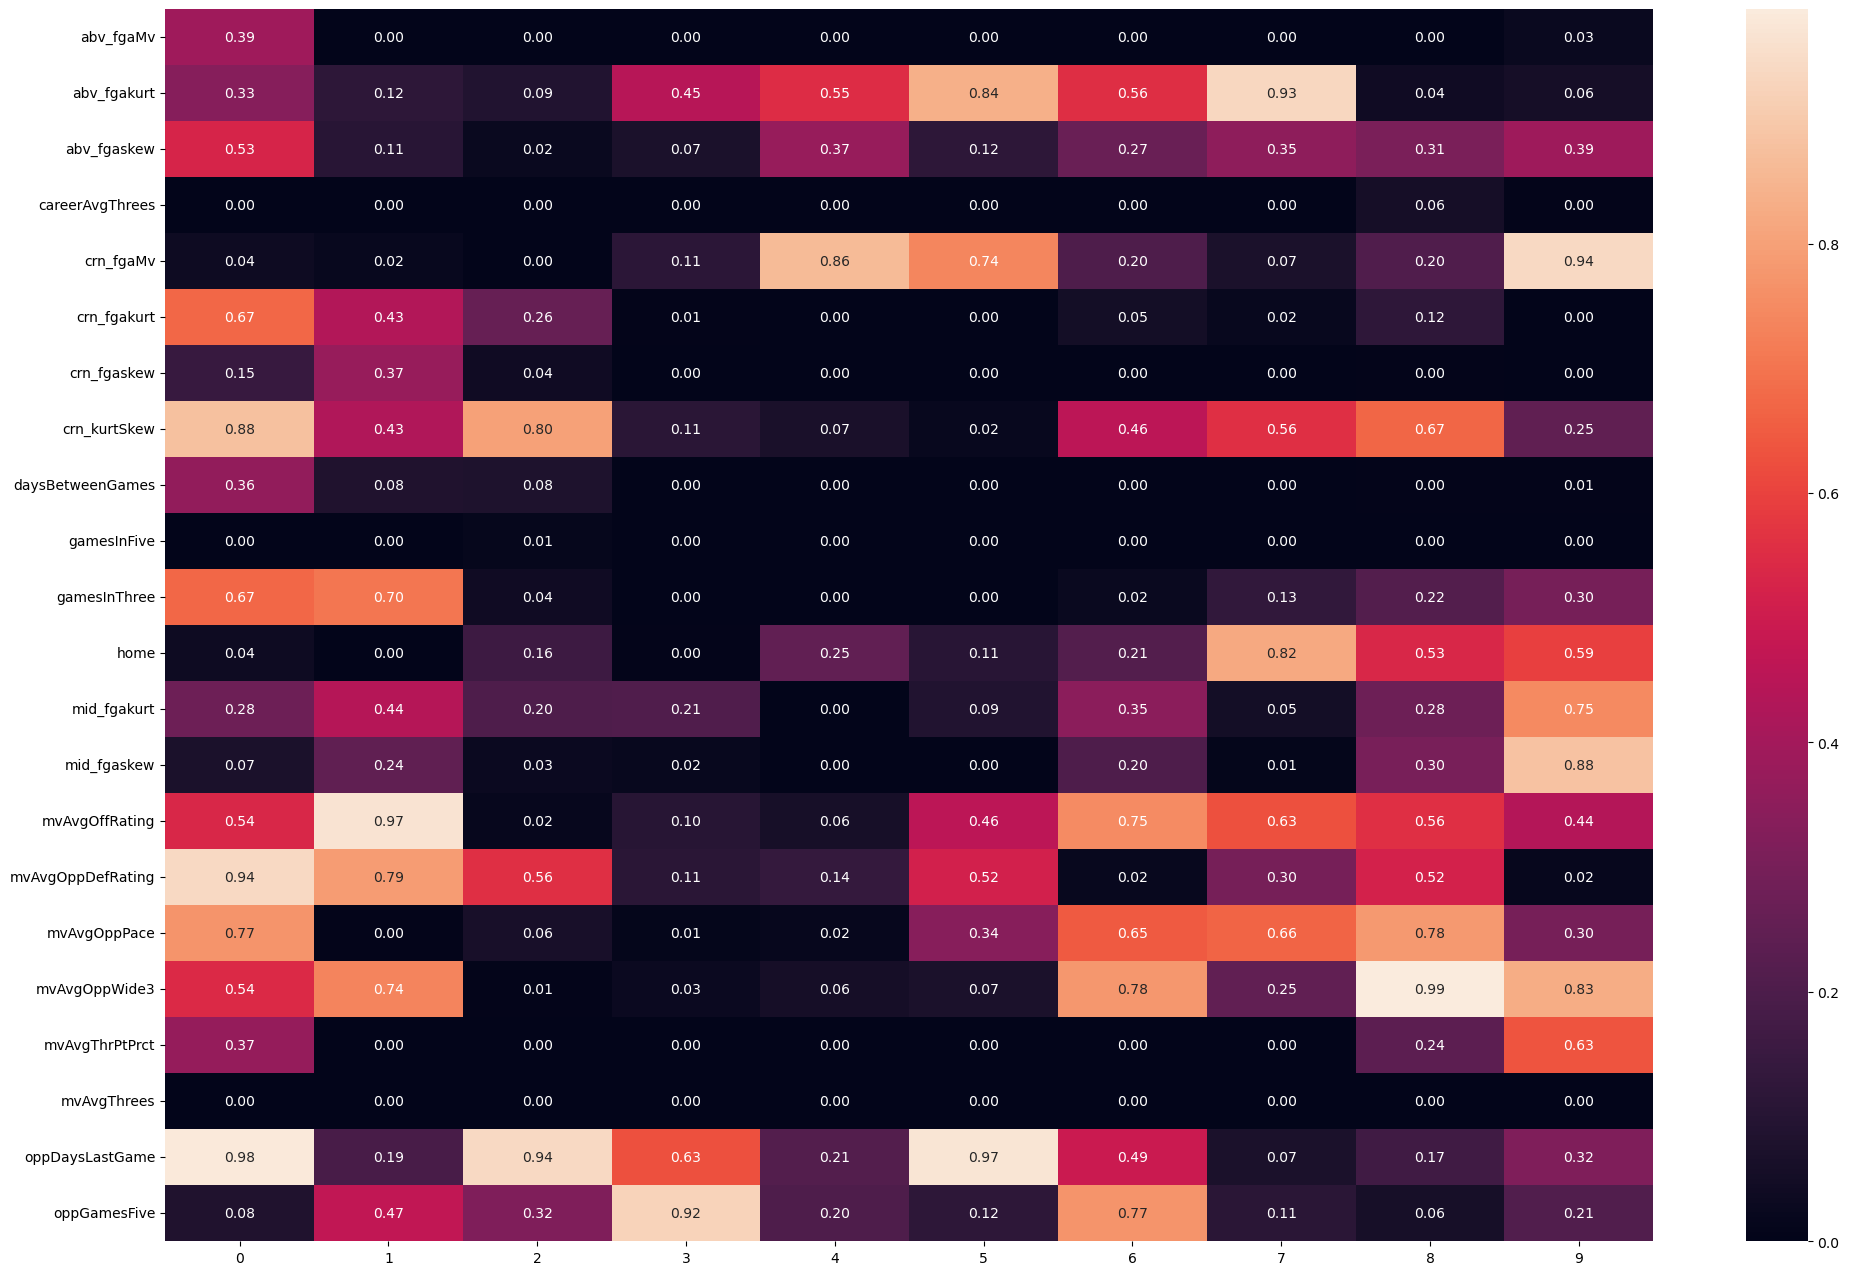

In [23]:
# noCareer = 
upMod = modTesting(ybin,yTbin,X,Xtest,jumperFeats)

In [2254]:
df = nba.threeData('data/sql/thrTesting.sql')
df= df.join(weighted_moving_avg(df,5,15,'crn_fga','player_id'))
df = df.join(weighted_moving_avg(df,5,15,'abv_fga','player_id'))

In [2255]:
d = dt.datetime.today().strftime('%Y-%m-%d')
yst = (pd.to_datetime(d) + pd.to_timedelta(-1,unit='day')).strftime(format='%Y-%m-%d')
td = df[(df.game_date==d) ]

In [2277]:
pd.read_sql('select * from teamLog where game_id = "0022401005"',nba.conn)

,game_id,game_date,team_id,inactive,count_inactive,assist_pct,off_rate,def_rate,pace,possessions,...,q1_pts,q2_pts,q3_pts,q4_pts,ot1_pts,ot2_pts,ot3_pts,ot4_pts,win,season
0,0022401005,2025-03-20,1610612744,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,2024-25
1,0022401005,2025-03-20,1610612761,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,2024-25


In [2256]:
# dct = {}
# for col in ['crn_fgaMv','abv_fgaMv']:
#     X[col] =ss.fit_transform(X[col].values.reshape(-1,1))
#     dct[col] = {'mean':ss.mean_,'std':ss.var_**.5}

In [2257]:
curYear = df[df.game_date.between('2024-10-01',d)]

In [2258]:
td['abv_kurtSkew'] = td.abv_fgakurt * td.abv_fgaskew
td['crn_kurtSkew'] = td.crn_fgakurt * td.crn_fgaskew
# td = td.join(weighted_moving_avg(td,5,15,'crn_fga','player_id'))
# td = td.join(weighted_moving_avg(td,5,15,'abv_fga','player_id'))

td = nba.cleanNaThr(td)
td = nba.scaleData(td)


In [2259]:
p = upMod.predict(td.filter(jumperFeats)).join(td[['name']])

In [2260]:
def kellyCrit(prob,odds):
    '''
    Calculates the kelly criterion to help determin betting size, will give as a percentage of bankroll to use
    Inputs: your probability of the event winning, odds (American) that you will be paid out if the win occurs
    Outputs: a float with the amount of your bankroll
    '''
    if odds > 0:
        return prob - (1-prob) / (odds / 100)
    else:
        return prob - (1-prob) / (100/np.abs(odds))
        
def convertPredsToOdds(preds,df):
    c = [10,9,8,7,6,5,4,3,2,1,0]
    finalo = pd.DataFrame(np.array([nba.convertPercentToOdds(v) for r in preds[c].cumsum(axis=1).values for v in r]).reshape(preds[c].shape),
                         columns=c,index=preds.index).drop(0,axis=1)
    overs = df[['name','team']].join(finalo.filter(preds.columns))
    #name matching
    overs['name'] = [x if re.search('[JS]r\.$',x)==None else x[:-1] for x in overs.name]
    return overs
def createFinalFrame(over,odds):
    over = over.melt(id_vars=['name','team',],var_name='threesMade')
    over.threesMade = over.threesMade -.5
    final = odds.merge(over[['name','team','threesMade','value']],how='left',on=['name','threesMade'])
    final = final[final.over_under=='Over']

    final['prob'] = np.where(final.value<0, abs(final.value) / (abs(final.value) + 100), 100/(final.value +100))
    final['DKKelly'] = [kellyCrit(p,odd) / 8 for p,odd in zip(final.prob,final.DraftKings)]
    final['FanDuelKelly'] = [kellyCrit(p,odd) / 8 for p,odd in zip(final.prob,final.FanDuel)]
    #final['espnKelly'] = [kellyCrit(p,odd) / 8 for p,odd in zip(final.prob,final['ESPN BET'])]
    final['dkBet'] = [x * 100 * 5 for x in final.DKKelly.values]
    final['fdBet'] = [x * 100 * 5 for x in final.FanDuelKelly.values]
    #final['espnBet'] = [x * 100 * 5 for x in final.espnKelly]
    return final

In [2261]:
def calc_parlay(d,probs,multipe = 62.5):
    '''
    d: a dictionary that has keys as the player name and the value is the minimum number to be achieved.
    probs: a dataframe that has the columns as the discrete outcomes and the index is the player names
    multiple: budget / kelly value - currently uses eighth kelly and 500 budget
    output: list of each combination (up to 4) for the parlay and the amount to spend. 
    '''
    

In [2262]:
odds  = pd.read_csv('data/csv/{}odds.csv'.format(d))

In [2263]:
overs = convertPredsToOdds(p,td)

In [2264]:
final = createFinalFrame(overs,odds)

In [2286]:
kellyCrit(100/234 * .345,1328 ) * 62.5

5.202299582947171

In [2283]:
overs[overs.team.isin(['NYK'])]

,name,team,1,2,3,4,5,6,7,8,9,10
100419,Karl-Anthony Towns,NYK,-606,-148,186,445,1110,2878,6744,9900,9900,9900
100431,OG Anunoby,NYK,-571,-143,185,475,1276,3006,8466,9900,9900,9900
100433,Josh Hart,NYK,-284,134,395,1040,2976,7227,9900,9900,9900,9900
100435,Mikal Bridges,NYK,-348,109,282,682,1730,4297,9900,9900,9900,9900
100437,Jalen Brunson,NYK,-607,-203,119,285,662,2047,9900,9900,9900,9900
100440,Mitchell Robinson,NYK,-106,370,1231,3625,9900,9900,9900,9900,9900,9900
100458,Precious Achiuwa,NYK,-101,432,1445,4701,9900,9900,9900,9900,9900,9900
100465,Miles McBride,NYK,-711,-163,168,406,985,2346,5578,9900,9900,9900


In [2287]:
final[final.fdBet>0].sort_values(by='fdBet',ascending=False).head(50)

,name,threesMade,over_under,DraftKings,FanDuel,team,value,prob,DKKelly,FanDuelKelly,dkBet,fdBet
229,Pascal Siakam,1.500,Over,102.500,-1.000,IND,-121.000,0.548,0.013,0.068,6.629,33.937
28,Brook Lopez,1.500,Over,-2.500,-1.000,MIL,123.000,0.448,0.054,0.055,27.165,27.682
187,Miles Bridges,2.500,Over,-107.500,-1.000,CHA,161.000,0.383,-0.035,0.047,-17.499,23.561
176,Matas Buzelis,2.500,Over,320.000,390.000,CHI,209.000,0.324,0.014,0.019,7.016,9.387
231,Pascal Siakam,2.500,Over,320.000,310.000,IND,190.000,0.345,0.018,0.017,8.755,8.343
232,Pascal Siakam,3.500,Over,950.000,900.000,IND,396.000,0.202,0.015,0.014,7.348,7.056
177,Matas Buzelis,3.500,Over,900.000,1000.000,CHI,441.000,0.185,0.012,0.013,5.892,6.458
5,Aaron Nesmith,3.500,Over,330.000,430.000,IND,278.000,0.265,0.005,0.012,2.605,5.845
3,Aaron Nesmith,2.500,Over,137.500,162.000,IND,128.000,0.439,0.004,0.012,1.894,5.753
46,D'Angelo Russell,3.500,Over,240.000,300.000,BKN,217.000,0.315,0.004,0.011,1.889,5.455


In [156]:
final[final.dkBet>1].sort_values(by='dkBet',ascending=False)

,name,threesMade,over_under,DraftKings,FanDuel,team,value,prob,DKKelly,FanDuelKelly,dkBet,fdBet
98,Chet Holmgren,1.500,Over,0.000,-107.000,OKC,123.000,0.448,0.056,-0.018,28.027,-8.859
423,Nickeil Alexander-Walker,2.500,Over,-2.500,NaN,MIN,141.000,0.415,0.050,NaN,25.019,NaN
236,Jamal Murray,0.500,Over,-900.000,-1000.000,DEN,-1512.000,0.938,0.047,0.040,23.728,19.851
129,Deni Avdija,1.500,Over,-2.500,NaN,POR,172.000,0.368,0.044,NaN,21.990,NaN
237,Jamal Murray,1.500,Over,-194.000,-196.000,DEN,-326.000,0.765,0.039,0.038,19.366,19.073
538,Zach Edey,0.500,Over,150.000,NaN,MEM,-122.000,0.550,0.031,NaN,15.578,NaN
0,Aaron Gordon,0.500,Over,-190.000,NaN,DEN,-280.000,0.737,0.030,NaN,14.803,NaN
443,Onyeka Okongwu,0.500,Over,115.000,NaN,ATL,-140.000,0.583,0.028,NaN,13.813,NaN
42,Bam Adebayo,0.500,Over,-140.000,NaN,MIA,-207.000,0.674,0.027,NaN,13.640,NaN
239,Jamal Murray,2.500,Over,160.000,162.000,DEN,-107.000,0.517,0.027,0.027,13.436,13.669


In [1385]:
#h2h
def h2h(fav,udog,spread=.5,ovrLine = 5.5):
    '''
    Takes in probabilites for player A (prbA) and player B (prbB) and spread between the two, determines the line for the spread and moneyline
    This assumes player A is the favored player
    If over under is enter will also provide the line for that
    input: array of probabilities for two players, spread (ie .05)
    output: text showing probility of player A winning (ml), against the spread and over under
    '''
    ovr= {}
    df = p[p.name.isin([fav,udog])].set_index('name')
    fsp = sum([df.loc[udog][i] * df.loc[fav][np.ceil(i+spread) if i+spread <10 else 10:].sum() for i in range(0,11)])
    usp = sum([df.loc[fav][i] * df.loc[udog][np.ceil(i-spread) if i-spread>0 else 0:].sum() for i in range(0,11)])
    fml = sum([df.loc[fav][i] * df.loc[udog][:i+1].sum() for i in range(0,11)])
    uml = sum([df.loc[udog][i] * df.loc[fav][:i+1].sum() for i in range(0,11)])
    undr = sum([df.loc[fav][i] * df.loc[udog][x]if x==i else df.loc[fav][i] * df.loc[udog][x] + df.loc[fav][x] * df.loc[udog][i]
             for i in np.arange(0,ovrLine) for x in np.arange(0,i+1) if i+x <ovrLine])
    ovr[fav] = {'spreadLine':nba.convertPercentToOdds(fsp),
                'spreadProb':round(fsp,3),
                'ml':nba.convertPercentToOdds(fml),
                'monyProb':round(fml,3)}
    ovr[udog] = {'spreadLine':nba.convertPercentToOdds(usp),
                'spreadProb':round(usp,3),
                'ml':nba.convertPercentToOdds(uml),
                'monyProb':round(uml,3)}
    ovr['over'] = {'underProb':undr,
                   'underMl':nba.convertPercentToOdds(undr),
                   'overProb':1-undr,
                   'overMl':nba.convertPercentToOdds(1-undr),
                  }
    return pd.DataFrame(ovr).T

In [2314]:
kellyCrit(.414,325) * 62.5

14.605769230769228

In [2312]:
h2h("Luka Doncic","Gary Trent Jr.",spread=1.5,ovrLine = 5.5)

,spreadLine,spreadProb,ml,monyProb,underProb,underMl,overProb,overMl
Luka Doncic,146.000,0.406,-293.000,0.746,NaN,NaN,NaN,NaN
Gary Trent Jr.,-145.000,0.594,141.000,0.414,NaN,NaN,NaN,NaN
over,NaN,NaN,NaN,NaN,0.540,-116.000,0.460,117.000


In [2098]:
nba.cur.execute('UPDATE plyrLogs SET team_id = "1610612749" where player_id = "1629645" and game_date > "2025-02-09"')
nba.conn.commit()

In [2124]:
pd.read_sql('select * from plyrLogs where player_id = "1629645" and GAME_DATE > "2025-02-10"',nba.conn)

,player_id,team_id,game_id,game_date,min,ftm,fta,reb,ast,tov,...,paint_fgm,mid_fgm,mid_fga,lc_fgm,lc_fga,rc_fgm,rc_fga,abv_fgm,abv_fga,Starter
0,1629645,1610612749,0022400776,2025-02-12,21.567,2.000,2.000,8.000,5.000,1.000,...,2.000,1.000,2.000,0.000,0.000,0.000,0.000,1.000,2.000,0.000
1,1629645,1610612749,0022400793,2025-02-20,15.450,3.000,3.000,0.000,2.000,2.000,...,0.000,1.000,2.000,0.000,0.000,NaN,NaN,0.000,1.000,0.000
2,1629645,1610612749,0022400799,2025-02-21,23.483,2.000,3.000,3.000,3.000,1.000,...,2.000,1.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1629645,1610612749,0022400817,2025-02-23,13.583,3.000,4.000,3.000,2.000,0.000,...,0.000,3.000,5.000,NaN,NaN,0.000,0.000,0.000,0.000,0.000
4,1629645,1610612749,0022400831,2025-02-25,11.113,0.000,0.000,0.000,0.000,4.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
5,1629645,1610612749,0022400846,2025-02-27,12.683,0.000,0.000,1.000,2.000,2.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,2.000,0.000
6,1629645,1610612749,0022400865,2025-03-01,12.400,5.000,6.000,2.000,3.000,2.000,...,1.000,2.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,1629645,1610612749,0022400884,2025-03-04,11.883,2.000,2.000,2.000,2.000,3.000,...,0.000,3.000,3.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000
8,1629645,1610612749,0022400897,2025-03-05,26.200,2.000,3.000,11.000,14.000,3.000,...,3.000,1.000,2.000,0.000,1.000,0.000,0.000,0.000,4.000,0.000
9,1629645,1610612749,0022400917,2025-03-08,22.785,0.000,0.000,2.000,2.000,2.000,...,0.000,3.000,3.000,0.000,0.000,0.000,0.000,2.000,2.000,0.000


In [2097]:
nba.teams

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,team_id,teamAbrv
0,1610612737,ATL
1,1610612738,BOS
2,1610612739,CLE
3,1610612740,NOP
4,1610612741,CHI
5,1610612742,DAL
6,1610612743,DEN
7,1610612744,GSW
8,1610612745,HOU
9,1610612746,LAC


In [2094]:
pd.read_sql('select * from players where name = "Kevin Porter Jr."',nba.conn)

,player_id,name,height,weight,pos,draft_year,pick,birthday,allstars,allnba_first,allnba_second,allnba_third,alld_first,alld_second,mip,dpoy,mvp,finals_mvp
0,1629645,Kevin Porter Jr.,76,203,Guard-Forward,2019,30,2000-05-04,None,None,None,None,None,None,None,None,None,None


In [2092]:
h2h("Derrick White","Cameron Johnson",spread=1.5,ovrLine=6.5)

,spreadLine,spreadProb,ml,monyProb,underProb,underMl,overProb,overMl
Derrick White,141.000,0.415,-263.000,0.726,NaN,NaN,NaN,NaN
Cameron Johnson,-140.000,0.585,135.000,0.424,NaN,NaN,NaN,NaN
over,NaN,NaN,NaN,NaN,0.652,-186.000,0.348,187.000


In [1905]:
nba.cur.execute('UPDATE teamLog SET game_date = "2025-03-16" where game_id = "0022400538"')
nba.cur.execute('UPDATE shotsAllowed SET game_date = "2025-03-16" where game_id = "0022400538"')
nba.cur.execute('UPDATE plyrLogs SET game_date = "2025-03-16" where game_id = "0022400538"')

In [1906]:
nba.conn.commit()

In [1904]:
pd.read_sql('select * from teamLog where game_date = "2025-01-11"',nba.conn)

,game_id,game_date,team_id,inactive,count_inactive,assist_pct,off_rate,def_rate,pace,possessions,...,q1_pts,q2_pts,q3_pts,q4_pts,ot1_pts,ot2_pts,ot3_pts,ot4_pts,win,season
0,0022400538,2025-01-11,1610612746,None,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,None,None,None,NaN,2024-25
1,0022400538,2025-01-11,1610612766,None,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,None,None,None,NaN,2024-25
2,0022400536,2025-01-11,1610612757,"203924,1629057,1631386",3.000,0.667,101.000,122.700,97.000,97.000,...,23.000,25.000,35.000,15.000,None,None,None,None,1.000,2024-25
3,0022400536,2025-01-11,1610612748,"1641815,1630696",2.000,0.705,122.700,101.000,97.000,97.000,...,29.000,37.000,28.000,25.000,None,None,None,None,0.000,2024-25
4,0022400534,2025-01-11,1610612765,"1631199,1642449,1641752,1642450,1631093",5.000,0.795,123.000,114.000,100.000,100.000,...,32.000,33.000,34.000,24.000,None,None,None,None,1.000,2024-25
5,0022400534,2025-01-11,1610612761,"1630639,1630647,1642419,1642279,1642367",5.000,0.675,114.000,123.000,100.000,100.000,...,32.000,34.000,27.000,21.000,None,None,None,None,0.000,2024-25
6,0022400533,2025-01-11,1610612756,"1626220,1641779,1631102,1631221",4.000,0.591,121.300,112.800,94.000,94.000,...,31.000,34.000,22.000,27.000,None,None,None,None,1.000,2024-25
7,0022400533,2025-01-11,1610612762,"203903,1630548,1641729,1628381,1641718,1641707",6.000,0.619,112.800,121.300,94.000,94.000,...,27.000,27.000,25.000,27.000,None,None,None,None,0.000,2024-25
8,0022400535,2025-01-11,1610612750,"1630545,1642399,1642265,1641803",4.000,0.787,122.500,124.500,102.000,102.000,...,33.000,32.000,38.000,22.000,None,None,None,None,0.000,2024-25
9,0022400535,2025-01-11,1610612763,"1642389,1641713,203935,1642285,1631246",5.000,0.521,124.500,122.500,102.000,102.000,...,35.000,29.000,35.000,28.000,None,None,None,None,1.000,2024-25


In [1320]:
tst = p[p.name.isin(['Zach LaVine',"Karl-Anthony Towns"])].set_index('name')
fav,udog = ['Zach LaVine',"Karl-Anthony Towns"]
ovrLine = 4.5

In [1327]:
ovrLine

4.5

In [1379]:
[(x,i) for i in range(0,int(ovrLine)+1) for x in range(0,i+1) if i+x <ovrLine]

[(0, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 1, 1, 1),
 (2, 0, 0, 2),
 (2, 1, 1, 2),
 (2, 2, 2, 2),
 (3, 0, 0, 3),
 (3, 1, 1, 3),
 (4, 0, 0, 4)]

[(0.016140905119060068, 0.0, 0.0),
 (0.0454271957948785, 0.025825589504816827, 0.0, 1.0),
 (0.07268391098886474, 1.0, 1.0),
 (0.05003855751471719, 0.021068941236469695, 0.0, 2.0),
 (0.08006213011327747, 0.05929673160705831, 1.0, 2.0),
 (0.06531600427973262, 2.0, 2.0),
 (0.03464589969009997, 0.012361683807252763, 0.0, 3.0),
 (0.05543374283050655, 0.03479090091443097, 1.0, 3.0),
 (0.02405793675183268, 0.004376254362395576, 0.0, 4.0)]

In [ ]:
### bill's regression code to work through
## assume we have 6 features
## we make a fake increasing "b"
b = np.arange(0, 6, 1).reshape(-1,1) ## forces linear and increasing
print(b)
## x represents our actual data in that observation
x = np.random.rand(6)
print('x = ',x)
## give it a constant
xb = np.concatenate([np.ones(b.shape), x.reshape(-1,1)], axis=1)
print('\nxb =',xb)
## run the regression and you can use each item
intSlope, residual, rank, s = np.linalg.lstsq(b, xb, rcond=None)
print('\nintercept:\t{:.4f}\nslope\t{:.4f}\nresid:\t{}\ns:\t{:.4f}'.format(*intSlope.flatten(),np.array2string(residual),s[0]))

In [ ]:
saData = nba.update_shots_allowed(games[games.ra_fga.isna()].game_date.unique())

In [ ]:
#lets look at some data from this year
today = dt.datetime.today().strftime(format='%Y-%m-%d')
yst = (pd.to_datetime(today) + pd.to_timedelta(-1,unit='day')).strftime(format='%Y-%m-%d')
pdf = pd.read_sql('''select name,pl.*,abv_fgm + lc_fgm + rc_fgm as ThreesMade,abv_fga + lc_fga + rc_fga as ThreesAtts
                    from plyrLogs pl left join players p on pl.player_id = p.player_id 
                    where game_date between '2024-10-01' and '{}' '''.format(yst),nba.conn)

In [ ]:
sns.histplot(pdf.ThreesAtts,binwidth=1)
plt.show()

In [ ]:
mnThrees = pdf.groupby(['player_id']).ThreesAtts.mean().dropna().values

In [ ]:
sns.histplot(pdf.groupby('player_id').ThreesAtts.mean())
plt.vlines(x = pdf.groupby(['player_id']).ThreesAtts.mean().quantile([.25,.5,.75,.8,.9]).values,ymin=0,ymax=100,color='red',linestyles='--')
plt.show()

In [ ]:
sns.histplot(pdf.groupby('player_id').ThreesMade.mean())
plt.vlines(x = pdf.groupby(['player_id']).ThreesMade.mean().quantile([.25,.5,.75,.8,.9]).values,ymin=0,ymax=100,color='red',linestyles='--')
plt.show()

In [ ]:
pdf.groupby(['player_id']).ThreesAtts.mean().quantile([.9])

In [ ]:
pdf[(pdf.groupby(['player_id']).ThreesAtts.transform('mean')>3)].player_id.nunique()

In [ ]:
pdf[pdf.groupby('player_id').ThreesAtts.transform('mean')>6.5].player_id.nunique()

In [ ]:
sns.histplot(((pdf.lc_fga + pdf.rc_fga) / pdf.ThreesAtts).fillna(0))
plt.vlines(((pdf.lc_fga + pdf.rc_fga) / pdf.ThreesAtts).fillna(0).quantile([.2,.4,.6,.8]),color='red',linestyle='--',ymin=0,ymax=2500)
plt.show()

In [ ]:
((pdf.lc_fga + pdf.rc_fga) / pdf.ThreesAtts).fillna(0).quantile([.2,.4,.6,.8])

In [ ]:
pdf.ThreesAtts.quantile([.2,.4,.5,.6,.8])

In [ ]:
today = dt.datetime.today().strftime('%Y-%m-%d')
gids = nba.get_games('{}-10-01'.format('2024'),today)
season = nba.get_schedule('2024')

In [535]:
## updating teamlog
def update_schedule(adds):
    '''Give a data frame with the game_date, game_id, team_id and home
    '''
    tcols = pd.read_sql('select * from teamLog limit 1',nba.conn).columns
    #adds = season[(~season.game_id.isin(gids.GAME_ID)) & (season.game_date<=today)]
    for col in tcols:
        if col not in adds.columns:
            adds[col] = None
    nba.insert_data(adds.filter(tcols),'teamLog')
    #updating playerlogs
    pcols = pd.read_sql('select * from plyrLogs limit 1',nba.conn).columns
    plyrs = pd.read_sql("select teamId as team_id, playerId as player_id from rosters where endDate is Null ",nba.conn)
    df = adds.merge(plyrs,how='left',on=['team_id'])
    for col in pcols:
        if col not in df:
            df[col] = None
    nba.insert_data(df.filter(pcols),'plyrLogs')
    #updating shotsallowed
    saCols = pd.read_sql('select * from shotsAllowed limit 1',nba.conn).columns
    #sadf = season[(~season.game_date.isin(saGames)) & (season.game_date<=today)]
    for col in saCols:
        if col not in adds:
            adds[col] = 0
    nba.insert_data(adds.filter(saCols),'shotsAllowed')

In [537]:
adds = pd.read_sql('select game_date,game_id,team_id, home from teamLog where game_date ="2025-02-19"',nba.conn)
pcols = pd.read_sql('select * from plyrLogs limit 1',nba.conn).columns
plyrs = pd.read_sql("select teamId as team_id, playerId as player_id from rosters where endDate is Null ",nba.conn)
df = adds.merge(plyrs,how='left',on=['team_id'])
for col in pcols:
    if col not in df:
        df[col] = None
nba.insert_data(df.filter(pcols),'plyrLogs')

plyrLogs has been updated with 34 rows


In [ ]:

pcols = pd.read_sql('select * from plyrLogs limit 1',nba.conn).columns
plyrs = pd.read_sql("select teamId as team_id, playerId as player_id from rosters where endDate is Null ",nba.conn)
df = adds.merge(plyrs,how='left',on=['team_id'])
for col in pcols:
    if col not in df:
        df[col] = None
nba.insert_data(df.filter(pcols),'plyrLogs')

In [ ]:
adds = pd.DataFrame([['2025-01-28','0022400660','1610612747',0]],columns = ['game_date','game_id','team_id','home'])

In [ ]:
adds = nba.get_games('2024-10-01','2025-03-30')

In [ ]:
adds.GAME_DATE.max()

In [ ]:
nba.conn.execute("DELETE FROM teamLog where game_id = '0022400537' ")
nba.conn.execute("DELETE FROM shotsAllowed where game_id = '0022400537'")
nba.conn.execute("DELETE FROM plyrLogs where game_id = '0022400537'")
nba.conn.commit()

In [ ]:
update_schedule(adds)

In [ ]:
df = season[(~season.game_id.isin(gids.GAME_ID)) &(season.game_date<=today)]
saCols = pd.read_sql('select * from shotsAllowed limit 1',nba.conn).columns
saGames = pd.read_sql("select * from shotsAllowed where game_date > '2024-10-01'",nba.conn).game_date.unique()
sadf = season[(~season.game_date.isin(saGames)) & (season.game_date<=today)]
for col in saCols:
    if col not in sadf:
        sadf[col] = 0
nba.insert_data(sadf.filter(saCols),'shotsAllowed')

In [ ]:
def change_games(gid,newDate):
    nba.conn.execute("UPDATE teamLog SET game_date = '{}'  WHERE game_id = '{}'".format(newDate,gid))
    nba.conn.execute("UPDATE plyrLogs SET game_date = '{}' WHERE game_id = '{}'".format(newDate,gid))
    nba.conn.execute("UPDATE shotsAllowed SET game_date = '{}' WHERE game_id = '{}'".format(newDate,gid))
    nba.conn.commit()
    print('Game updated')


In [ ]:
pd.read_sql("select * from teams where teamAbrv in('HOU','ATL')",nba.conn)

In [ ]:
season = nba.get_schedule(year)
tcols = pd.read_sql('select * from teamLog limit 1',nba.conn).columns
adds = season[~season.game_id.isin(gids.game_id)]
for col in tcols:
    if col not in adds.columns:
        adds[col] = None
nba.insert_data(adds.filter(tcols),'teamLog')
#updating playerlogs
pcols = pd.read_sql('select * from plyrLogs limit 1',nba.conn).columns
plyrs = pd.read_sql("select teamId as team_id, playerId as player_id from rosters where endDate is Null ",nba.conn)
df = adds.merge(plyrs,how='left',on=['team_id'])
for col in pcols:
    if col not in df:
        df[col] = None
nba.insert_data(df.filter(pcols),'plyrLogs')
#updating shotsallowed
df = season[~season.game_id.isin(gids.game_id)]

In [593]:
### TRADE HAPPENED! 
nba.cur.execute("select * from roster_view where name in ('Anthony Davis','Luka Doncic','Max Christie', 'Maxi Kleber')").fetchall()

[('Max Christie', '1631108', 'LAL', '1610612747'),
 ('Anthony Davis', '203076', 'LAL', '1610612747'),
 ('Luka Doncic', '1629029', 'DAL', '1610612742'),
 ('Maxi Kleber', '1628467', 'DAL', '1610612742')]

In [594]:
tdf = pd.read_sql("select * from roster_view where name in ('Anthony Davis','Luka Doncic','Max Christie', 'Maxi Kleber')",nba.conn)
tdf['newTeam'] = [tdf.team_id.unique()[tdf.team_id.unique()!=x][0] for x in tdf.team_id]
tdf['tradeDate'] = "2025-02-02"

In [726]:
tdf.player_id.values

array(['1631108', '203076', '1629029', '1628467'], dtype=object)

In [ ]:
pd.read_sql('select * from teams',nba.conn)

In [ ]:
tdf = pd.read_sql('''select * from roster_view where name in ("Caris LeVert",
"Georges Niang", "De\'Andre Hunter", "Jimmy Butler", "Andrew Wiggins", "Dennis Schroder","Terance Mann","Bones Hyland",
"Bogdan Bogdanovic","Jusuf Nurkic","Vasilije Micic","Cody Martin","Dalton Knecht","Davion Mitchell","Kyle Anderson","KJ Martin",
"Cam Reddish","Josh Richardson","Bruce Brown","Kelly Olynyk","Khris Middleton","Kyle Kuzma",
"AJ Johnson","Patrick Baldwin Jr","Quentin Grimes","Caleb Martin")''',nba.conn)

In [ ]:
tdf['newTeam'] = [1610612758,1610612741,1610612759,1610612741,1610612741,1610612758,1610612759]
tdf['tradeDate'] = '2025-02-02'

In [ ]:
t

In [ ]:
tdf['newTeam'] = [1610612748,1610612746,1610612740,1610612744,1610612755,1610612739,1610612737,
 1610612764,1610612766,1610612749,1610612737,1610612737,1610612742,1610612756,1610612762,
 1610612756,1610612764,1610612748, 1610612737,1610612766,1610612740,1610612766,0,1610612748,1610612765]

In [ ]:
tdf.replace(0,1610612762,inplace=True)

In [ ]:
tdf['tradeDate'] = '2025-02-05'

In [1137]:
# d['teamId'] = '1610612744'
# d['startDate'] = '2024-12-16'
# d['endDate'] = None
# nba.insert_data(d,'rosters')
#remove player's upcoming schedule
def trade_update(df):
    '''dictionary with all players being the key and then key, value pairs for the values of trade_date and new_team.
    Will update rosters with the new players and print out a statement stating how many rows have been changed for each player
    Inputs: dictionary
    Output: None, print statement for update
    '''
    date = df.tradeDate.unique()[0]
    pids = ','.join(df.player_id.unique())
    nba.cur.execute("DELETE FROM plyrLogs WHERE player_id in ({})  and game_date >= '{}' ".format(pids,date))
    nba.conn.commit()
    #update player's schedule with new team
    lst = df.filter(['player_id','newTeam','tradeDate']).values
    for l in lst:
        q ="select '{}' as player_id,team_id,game_date,game_id from teamLog where team_id = '{}' and game_date > '{}'".format(*l)
        new = pd.read_sql(q,nba.conn)
        pcols = pd.read_sql('select * from plyrLogs limit 1',nba.conn).columns
        for col in pcols:
            if col not in new.columns:
                new[col] = None
        nba.insert_data(new.filter(pcols),'plyrLogs')

In [1138]:
trade_update(chk)

plyrLogs has been updated with 20 rows


In [1119]:
g24 = [date+"T12:00:00z" for date in nba.get_games("2024-10-01",yst).GAME_DATE.unique()]


In [1135]:
chk = pd.DataFrame([['1642261',"1610612747","2025-03-07"]],columns = ['player_id','newTeam','tradeDate'])

,player_id,tradeDate,newTeam
0,1642261,1610612747,2025-03-07


In [1121]:
lst = trade_update(pd.DataFrame([['1642261',"1610612747","2025-03-07"]],columns = ['player_id','tradeDate','newTeam']))

In [1122]:
for l in lst:
    print(l)

['1642261' '2025-03-07' '1610612747']


In [730]:
def oddsData(start,end):
    '''ISO Formatted dates for today and tomorrow returns the games that will be played today ids for odds pulls
    Inputs: isoformatted dates for today and tomorrow
    Output: list of game ids
    '''
    dct = json.loads(open('config.json','r').read())
    eventURL = 'https://api.the-odds-api.com/v4/historical/sports/basketball_nba/events'
    
    key = dct.get('oddsApi').get('paid')
    r = requests.get(eventURL.format(key,start,end))
    return [d['id'] for d in r.json()],key


events,akey = oddsData(g24[2],g24[1])

In [733]:
r.get()

AttributeError: 'Response' object has no attribute 'get'

In [ ]:
eventURL = 'https://api.the-odds-api.com/v4/sports//events?apiKey={}&dateFormat=iso&commenceTimeFrom={}&commenceTimeTo={}'.format(

In [718]:
chk = oddsData(g24[0])

bfd4f5da3433f0f9013e9d16a4933c41


TypeError: string indices must be integers, not 'str'

In [716]:
chk

<Response [422]>

In [ ]:
##### historical information
hist = pd.DataFrame()
for event in events:
    r = requests.get(url.format(event,akey))
    game = r.json()
    for key in game.get('bookmakers'):
        bk = key.get('title')
        for mrkt in key.get('markets'):
            temp = pd.DataFrame(mrkt.get('outcomes'))
            temp.columns = ['over_under','name','price','threesMade']
            temp['book'] = bk
            temp['mrkt'] = mrkt
            hist = pd.concat([temp,hist])   
odds = hist.pivot_table(index=['name','threesMade','over_under'],columns=['book']).reset_index()
odds.columns = [col[1] if col[1]!= '' else col[0] for col in odds.columns]

In [ ]:
############getting quarter info

In [ ]:
from nba_api.stats.endpoints import BoxScoreAdvancedV2,PlayerGameLogs,LeagueDashPlayerShotLocations

In [ ]:
LeagueDashPlayerShotLocations(

In [ ]:
tl = pd.read_sql('select * from teamLog where game_date between "2022-10-01" and "{}"'.format(yst),nba.conn)

In [ ]:
tl

In [ ]:
dates = tl[tl.q1_pts.isna()].game_date.unique()

In [ ]:
nba.get